# Exercises in Fairness in Machine Learning

In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay


## Exercise 1

For this exercise, we will use the `adult` dataset (available on moodle or from the [UCI Machine Learning repository](https://archive.ics.uci.edu/dataset/2/adult)). Do the following:

1. Load in the dataset and correct the error in the income column (replace the "." with the empty string such that there are only two categories).
2. Create an X dataset using the variables "age", "workclass", "education", "occupation", "race", "sex", "hours-per-week". For the categorical variables with missing values, replace the missing values with a new category "Unknown". Also replace any values that are "?" with the value "Unknown (using `str.replace`, for instance)
3. Turn the five categorical variables in X into dummy variables and remove the original five variables (This will probably give you around 44 columns in X)
4. Create the response variable y, such that it is 1 if the `income` variable in the adult dataset is `>50K` and 0 if the value is `<=50K`.
5. Do a train-test split with 30% of the data for test (using `random_state=123`) and train a `XGBoost` classification model on the training data.
6. Evaluate your models using various evaluation metrics and look at the confusion matrix of your model.
7. To be able to calculate the various fairness metrics in regard to the variable `sex`, we need to construct two separate confusion matrices for the test dataset, one for `female` and one for `male`. First, create separate test sets for `female` and `male` as well as the predicted values for each gender. That is, create `X_test_female`, `X_test_male`, `y_test_female`, `y_test_male`, `y_pred_female`, and `y_pred_male`. (Hint: You can create `X_test_female` by `X_test_female = X_test[X_test["sex_Male"] == 0]` and `y_test_male` by `y_test_male = y_test[X_test["sex_Male"] == 1]`, for instance.)
8. Calculate the accuracy for female and male for the XGBoost model and comment on the results.
9. We can now create the True Positive (TP), True Negative (TN), False Positive (FP), and False Negative (FN) for each gender. That is, calculate the eight values `TP_f`, `TN_f`, `FP_f`, `FN_f`, `TP_m`, `TN_m`, `FP_m`, and `FN_m`. (Hint: You can calculate the False Positive for female (FP_f) by `FP_f = sum((y_test_female == 0) & (y_pred_female == 1))`.)
10. Is there error rate balance across different genders, i.e. are the false positive rate (FPR) and false negative rate (FNR) the same across the two genders?
11. Is there predictive parity across different genders?
12. Is there Statistical parity across different genders?
13. [Discussion question] Can your any of your models be used to make fair salary predictions?
14. [Discussion question] In what sense is the `adult` dataset biased (unfair)?
15. [Discussion question] If the dataset is biased, where could the bias potentially come from?
16. [Optional] If you balance the number of males and females in the dataset (like we balanced the response variable in the Churn example), will you model become more fair?

In [2]:
# Read the data
data = pd.read_csv('adult.csv')
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [3]:
data['income'] = data['income'].str.strip().str.replace(r'\.', '', regex=True)
print(data['income'].unique())

['<=50K' '>50K']


# 2. 
Create an X dataset using the variables "age", "workclass", "education", "occupation", "race", "sex", "hours-per-week". For the categorical variables with missing values, replace the missing values with a new category "Unknown". Also replace any values that are "?" with the value "Unknown (using `str.replace`, for instance)

In [20]:
# Select the relevant columns
X = data[['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'hours-per-week']]

# Replace missing values with 'Unknown'
X.loc[:, 'workclass'] = X['workclass'].fillna('Unknown')
X.loc[:, 'occupation'] = X['occupation'].fillna('Unknown')
X.loc[:, 'race'] = X['race'].fillna('Unknown')
X.loc[:, 'sex'] = X['sex'].fillna('Unknown')

# Replace '?' with 'Unknown'
X = X.replace('?', 'Unknown')

X.head()

,age,workclass,education,occupation,race,sex,hours-per-week
0,39,State-gov,Bachelors,Adm-clerical,White,Male,40
1,50,Self-emp-not-inc,Bachelors,Exec-managerial,White,Male,13
2,38,Private,HS-grad,Handlers-cleaners,White,Male,40
3,53,Private,11th,Handlers-cleaners,Black,Male,40
4,28,Private,Bachelors,Prof-specialty,Black,Female,40


# 3. 
Turn the five categorical variables in X into dummy variables and remove the original five variables (This will probably give you around 44 columns in X)

In [5]:
X = pd.get_dummies(X, columns=['workclass', 'education', 'occupation', 'race', 'sex'], drop_first=True)
X.shape

(48842, 44)

In [6]:
X.head()

,age,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Unknown,workclass_Without-pay,...,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,occupation_Unknown,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,39,40,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,True
1,50,13,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,True
2,38,40,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
3,53,40,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
4,28,40,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


# 4. 
Create the response variable y, such that it is 1 if the `income` variable in the adult dataset is `>50K` and 0 if the value is `<=50K`.

In [7]:
y = data['income'].apply(lambda x: 1 if x == '>50K' else 0)
y.head()

0    0
1    0
2    0
3    0
4    0
Name: income, dtype: int64

# 5. 
Do a train-test split with 30% of the data for test (using `random_state=123`) and train a `XGBoost` classification model on the training data.

In [8]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Train the XGBoost classification model
model = xgb.XGBClassifier(random_state=123)
model.fit(X_train, y_train)

# Print the model
print(model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)


# 6. 
Evaluate your models using various evaluation metrics and look at the confusion matrix of your model.

              precision    recall  f1-score   support

           0       0.85      0.93      0.89     11166
           1       0.67      0.47      0.55      3487

    accuracy                           0.82     14653
   macro avg       0.76      0.70      0.72     14653
weighted avg       0.81      0.82      0.81     14653



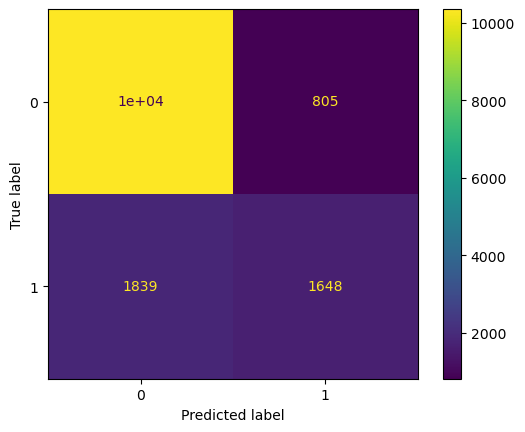

In [21]:
# Predict the test set results
y_pred = model.predict(X_test)

# Generate the classification report
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()

In [22]:
print(confusion_matrix(y_test, y_pred))


[[10361   805]
 [ 1839  1648]]


The model is better at predicting low-income (0) individuals because of the higher number of support

### Precision
the model is correct at `predicting` low-income 85% of the time whilee only correct predicts high-income 67% of the time

### Recall

`Identifies` 93% of actaul low-income correcctly and only 47% of the high-income individuals

### F1-score

The f1-score is great at predict and recall the low-income individuals, but lack at predicting and especially recall the high-income individuals. This could be because of the higher representation of low-income individuals as stated before


# 7. 
To be able to calculate the various fairness metrics in regard to the variable `sex`, we need to construct two separate confusion matrices for the test dataset, one for `female` and one for `male`. First, create separate test sets for `female` and `male` as well as the predicted values for each gender. That is, create `X_test_female`, `X_test_male`, `y_test_female`, `y_test_male`, `y_pred_female`, and `y_pred_male`. (Hint: You can create `X_test_female` by `X_test_female = X_test[X_test["sex_Male"] == 0]` and `y_test_male` by `y_test_male = y_test[X_test["sex_Male"] == 1]`, for instance.)

In [ ]:
# Create separate test sets for female and male
X_test_female = X_test[X_test["sex_Male"] == 0]
X_test_male = X_test[X_test["sex_Male"] == 1]
y_test_female = y_test[X_test["sex_Male"] == 0]
y_test_male = y_test[X_test["sex_Male"] == 1]

# Create predicted values for each gender
y_pred_female = y_pred[X_test["sex_Male"] == 0]
y_pred_male = y_pred[X_test["sex_Male"] == 1]

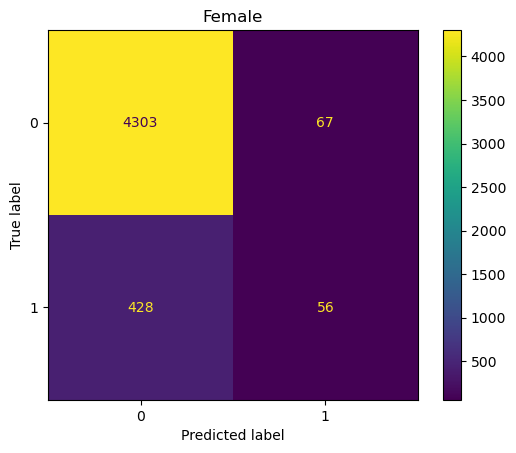

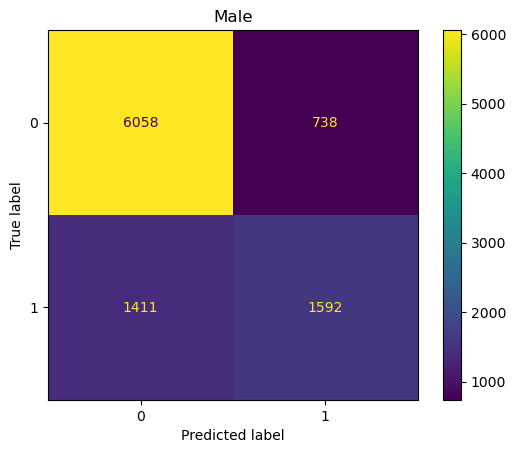

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test_female, y_pred_female)).plot()
plt.title("Female")
ConfusionMatrixDisplay(confusion_matrix(y_test_male, y_pred_male)).plot()
plt.title("Male")
plt.show()

# 8. 
Calculate the accuracy for female and male for the XGBoost model and comment on the results.

the accuracy can be caalculated like so: Accuracy = (TP + TN) / (TP + FN + FP + TN) 
but in this case we will use accuracy_score from sklearn.metrics

In [13]:
# Calculate accuracy for female
accuracy_female = accuracy_score(y_test_female, y_pred_female)
print(f'Accuracy for female: {accuracy_female}')

# Calculate accuracy for male
accuracy_male = accuracy_score(y_test_male, y_pred_male)
print(f'Accuracy for male: {accuracy_male}')

Accuracy for female: 0.8980222496909765
Accuracy for male: 0.7806919073374834


The model is much better at predicting income levels for women than for men. 
This could mean that the patterns for women are clearer than they are for men

# 9. 
We can now create the True Positive (TP), True Negative (TN), False Positive (FP), and False Negative (FN) for each gender. That is, calculate the eight values `TP_f`, `TN_f`, `FP_f`, `FN_f`, `TP_m`, `TN_m`, `FP_m`, and `FN_m`. (Hint: You can calculate the False Positive for female (FP_f) by `FP_f = sum((y_test_female == 0) & (y_pred_female == 1))`.)

In [14]:
# Calculate TP, TN, FP, FN for female
TP_f = sum((y_test_female == 1) & (y_pred_female == 1))
TN_f = sum((y_test_female == 0) & (y_pred_female == 0))
FP_f = sum((y_test_female == 0) & (y_pred_female == 1))
FN_f = sum((y_test_female == 1) & (y_pred_female == 0))

# Calculate TP, TN, FP, FN for male
TP_m = sum((y_test_male == 1) & (y_pred_male == 1))
TN_m = sum((y_test_male == 0) & (y_pred_male == 0))
FP_m = sum((y_test_male == 0) & (y_pred_male == 1))
FN_m = sum((y_test_male == 1) & (y_pred_male == 0))

print(f'TP_f: {TP_f}, TN_f: {TN_f}, FP_f: {FP_f}, FN_f: {FN_f}')
print(f'TP_m: {TP_m}, TN_m: {TN_m}, FP_m: {FP_m}, FN_m: {FN_m}')

TP_f: 56, TN_f: 4303, FP_f: 67, FN_f: 428
TP_m: 1592, TN_m: 6058, FP_m: 738, FN_m: 1411


# 10. 
Is there error rate balance across different genders, i.e. are the false positive rate (FPR) and false negative rate (FNR) the same across the two genders?

In [15]:
# Calculate FPR and FNR for females
FPR_f = FP_f / (FP_f + TN_f)
FNR_f = FN_f / (FN_f + TP_f)

# Calculate FPR and FNR for males
FPR_m = FP_m / (FP_m + TN_m)
FNR_m = FN_m / (FN_m + TP_m)

print(f'False Positive Rate for females: {FPR_f}')
print(f'False Negative Rate for females: {FNR_f}')
print(f'False Positive Rate for males: {FPR_m}')
print(f'False Negative Rate for males: {FNR_m}')

False Positive Rate for females: 0.015331807780320367
False Negative Rate for females: 0.8842975206611571
False Positive Rate for males: 0.10859329017068864
False Negative Rate for males: 0.4698634698634699


It is more likely to predict low-income men as high-income individuals than women. As shown in the FPR.

The FNR show that 88% of the time it fails to predict the high-income females, and only 47% for men (which is still high)


# 11. 
Is there predictive parity across different genders?
- Here we will use Precision (/positive predictive value) TP / (TP + FP)

In [16]:
# Calculate PPV for females
PPV_f = TP_f / (TP_f + FP_f)

# Calculate PPV for males
PPV_m = TP_m / (TP_m + FP_m)

print(f'Positive Predictive Value for females: {PPV_f}')
print(f'Positive Predictive Value for males: {PPV_m}')

Positive Predictive Value for females: 0.45528455284552843
Positive Predictive Value for males: 0.6832618025751073


When the model predict a high-income, it is correct 68% of the time for men and 46% for women, this aligns with the lower fpr for the women and higher fnr for women aswell.

# 12. 
Is there Statistical parity across different genders?

In [17]:
# Calculate the proportion of positive predictions for females
positive_female = sum(y_pred_female)
total_female = len(y_pred_female)
proportion_female = positive_female / total_female

# Calculate the proportion of positive predictions for males
positive_male = sum(y_pred_male)
total_male = len(y_pred_male)
proportion_male = positive_male / total_male

print(positive_female)
print(total_female)
print(positive_male)
print(total_male)

print(f'Proportion of positive predictions for females: {proportion_female}')
print(f'Proportion of positive predictions for males: {proportion_male}')

123
4854
2330
9799
Proportion of positive predictions for females: 0.02533992583436341
Proportion of positive predictions for males: 0.23777936524135115


the prediction on high-income for females is very low (2.5%) and at nearly 10 times more (23.8%) the men is predicted to have a high income 

In [18]:
stat_parity_diff = abs(proportion_male - proportion_female)
print(f"Statistical Parity Difference: {stat_parity_diff}")

Statistical Parity Difference: 0.21243943940698773


The SPD is ideally suppose to be around 0 for fairness in the predictions.
The large value is indicating there is a bias regaring the prediction of a higher income towards the men  than the females

13. [Discussion question] Can your any of your models be used to make fair salary predictions?
14. [Discussion question] In what sense is the `adult` dataset biased (unfair)?
15. [Discussion question] If the dataset is biased, where could the bias potentially come from?

### 13. Can any of your models be used to make fair salary predictions?

No, not in the current state. As shown, the model is 10x more likely to predict a high-income for men than women (23.8% and 2.5%). 
The SPD is also very high, which confirms the bias towards males. when prediction high-income

### 14. In what sense is the `adult` dataset biased (unfair)?

males are represented more than women in high-income category

males are also in general overrepresented in this dataset
